In [10]:
import os
from collections import defaultdict
import numpy as np

log_dir = './logs'
experiment_logs = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list)))))

for filename in os.listdir(log_dir):
    if filename.endswith('.log'):
        parts = filename.split('-')
        method = '-'.join(parts[0:1])
        experiment_name = '-'.join(parts[1:2])
        dataset = '-'.join(parts[2:3])
        if method == "Auncel":
            k = int('-'.join(parts[3:4]))
            error = float(parts[4:5][0][:-4])
            if dataset == "bert":
                nlist = 128
            else:
                nlist = 1024
        else:
            nlist = '-'.join(parts[3:4])
            k = int('-'.join(parts[4:5]))
            if method == "ConANN":
                error = float(parts[5:6][0])
            else:
                error = float(parts[5:6][0][:-4])

        with open(os.path.join(log_dir, filename), 'r') as file:
            experiment_logs[experiment_name][method][dataset][k][error] = [float(line.strip()) for line in file.readlines()]

datasets = [j for j in experiment_logs['efficiency']['ConANN'].keys()]
print(datasets)

data = experiment_logs['error']['ConANN']['bert'][100][0.1]
average = np.mean(data)
print(average)

data = experiment_logs['error']['Auncel']['deep10M'][100][0.1]
average = np.mean(data)
print(average)

['gist', 'sift1M', 'deep10M', 'bert', 'fasttext']
0.10546579307860263
0.00292199903


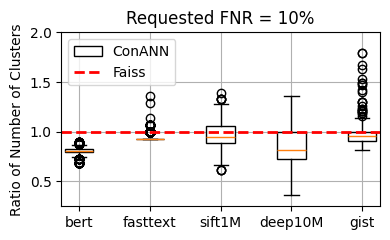

In [25]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10}) 
experiment_name = 'efficiency'
k_value = 100
error_value = 0.1  # Single error value
target_datasets = ['bert', 'fasttext', 'sift1M', 'deep10M', 'gist']
methods = ['ConANN', 'Faiss']

fig, ax = plt.subplots(figsize=(4, 2.5))

data_to_plot = {dataset: {'ConANN': [], 'Faiss': []} for dataset in target_datasets}
faiss_baselines = {}  # To store Faiss values for ratio calculation

for target_dataset in target_datasets:
    for method in methods:
        try:
            values = experiment_logs[experiment_name][method][target_dataset][k_value][error_value]
            data_to_plot[target_dataset][method] = values
            if method == 'Faiss' and len(values) > 0:
                faiss_baselines[target_dataset] = np.median(values)  # Store median Faiss value
        except KeyError:
            continue

# Prepare data for boxplots; ConANN values will be ratios to Faiss
boxplot_data = []
positions = []
labels = []
pos = 1

for dataset in target_datasets:
    conann_values = data_to_plot[dataset]['ConANN']
    faiss_values = data_to_plot[dataset]['Faiss']
    
    if len(conann_values) > 0 or len(faiss_values) > 0:
        if len(conann_values) > 0 and dataset in faiss_baselines:
            faiss_baseline = faiss_baselines[dataset]
            conann_ratios = [v / faiss_baseline for v in conann_values]
            boxplot_data.append(conann_ratios)
            positions.append(pos)
            labels.append('ConANN')
            pos += 1
        if len(faiss_values) > 0:
            # Faiss will be represented as a horizontal line at y=1
            pass
        pos += 1

if boxplot_data:
    box = ax.boxplot(boxplot_data, positions=positions, patch_artist=True, widths=0.8)
    for patch in box['boxes']:
        patch.set_facecolor('white')

ax.axhline(y=1, color='red', linestyle='--', linewidth=2)

dataset_positions = []
dataset_labels = []
current_pos = 1
for dataset in target_datasets:
    conann_count = len(data_to_plot[dataset]['ConANN'])
    faiss_count = len(data_to_plot[dataset]['Faiss'])
    if conann_count > 0 or faiss_count > 0:
        if conann_count > 0:
            dataset_positions.append(current_pos)
            current_pos += 2
        else:
            dataset_positions.append(current_pos)
            current_pos += 2
        dataset_labels.append(dataset)

ax.set_xticks(dataset_positions)
ax.set_xticklabels(dataset_labels)

ax.set_title(f'Requested FNR = {int(error_value * 100)}%')
ax.grid(True)
ax.set_ylim(0.25, 2) 

from matplotlib.patches import Patch
from matplotlib.lines import Line2D 
legend_elements = [
        Patch(facecolor='white', edgecolor='black', linewidth=1.0, label='ConANN'),
        Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='Faiss')
]
ax.legend(handles=legend_elements, loc='upper left')

ax.set_ylabel('Ratio of Number of Clusters')
plt.tight_layout()
plt.savefig(f'adaptivity-k={k_value}-error-{error_value}.pdf', format='pdf')
plt.show()